In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms import community
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import pathlib
import random

## Getting the bipartite graph

In [440]:
# GLOBALS

BIGRAPH_politi, LABELS_politi = 'user_article_raw.bigraph', "../small_dataset/politifact"
BIGRAPH_gossip, LABELS_gossip = 'user_article_raw_gossipcop.bigraph', "../small_dataset/gossipcop"

BIGRAPH_FILE, LABELS_FILE = BIGRAPH_politi, LABELS_politi
USER_PROFILES_FILE = '../small_dataset/user_profiles/'

In [464]:
def get_article_df(datadir, labels):
    A_nodes = get_article_nodes(G)
    a_lists = []
    for label in ['/real/', '/fake/']:
        for a in A_nodes:
            newscontent = datadir + label + a + '/news content.json'
            if not os.path.isfile(newscontent):
                continue
            with open(newscontent, 'r') as f:
                try:
                    line = f.readline()
                    u = json.loads(line)
                    lst = [
                        a,
                        u['source'],
                        u['url'],
                        u['title'],
                        u['publish_date'],
                        labels[a]
                    ] 
                    a_lists.append(lst) 
                except json.decoder.JSONDecodeError:
                    pass
    a_df = pd.DataFrame(a_lists, columns=['id', 'source', 'url', 'title', 'publish_date', 'label'])
    a_df = a_df.set_index(['id'])
    return a_df

sources = get_article_df(LABELS_politi, labels)

In [490]:
sources.groupby(['source', 'label']).count().sample(60).sort_values(by='source')

,,url,title,publish_date
source,label,,,
http://abcnews.go.com,0,2,2,0
http://beforeitsnews.com,1,1,1,1
http://gloria.tv,1,1,1,0
http://londonwebnews.com,1,1,1,1
http://me.me,1,1,1,0
http://mightynest.com,1,1,1,0
http://minnesota.cbslocal.com,0,1,1,1
http://now8news.com,1,1,1,1
http://nyeveningnews.com,1,1,1,1


In [428]:
# USERS

# Get dataframe consisting of users and their metadata

import json
from json.decoder import JSONDecodeError
import pandas as pd

def get_user_df(userdir):
    user_lists = []
    user_dir = pathlib.Path(userdir)
    for i, ujson in enumerate(os.listdir(user_dir)):
        with open(userdir+ujson, 'r') as f:
            try:
                line = f.readline()
                u = json.loads(line)
                lst = [
                    str(u['id']),
                    u['screen_name'],
                    u['verified'],
                    u['followers_count'],
                    u['friends_count'],
                    u["favourites_count"],
                    -1,
                    "NONE"
                ] 
                user_lists.append(lst) 
                if i % 10000 == 0:
                    print(f"Done with {i}")
            except json.decoder.JSONDecodeError:
                pass
    user_df = pd.DataFrame(user_lists, columns=['id', 'scrname', 'verified', 'followers_ct', 'friends_ct', "favourites_ct", "credibility", "authored"])
    user_df = user_df.set_index(['id'])
    return user_df

UDF = get_user_df(USER_PROFILES_FILE)

Done with 0
Done with 10000
Done with 20000
Done with 30000
Done with 40000
Done with 50000


In [344]:
# UTILITIES

# Return a set of users who mentioned articles
# Returns 
# dict (users ---> #-mentions)
def get_adjacent_set(B, set1):
    adjacent = dict()
    for item in set1:
        edges = B.edges(item)
        for edge in edges:
            adjacent[edge[1]] = adjacent.get(edge[1], 0) + 1
    return adjacent

def isuser(node):
    return len(node) < 3 or (node[:3] != 'pol' and node[:3] != 'gos')

def get_article_nodes(G):
    return [x for x in list(G.nodes) if (len(x) > 3 and x[:3] == 'pol') or (len(x) > 3 and x[:3] == 'gos')]

def get_user_nodes(G):
    return [x for x in list(G.nodes) if (len(x) < 3 or (x[:3] != 'pol' and x[:3] != 'gos'))]

def get_true_label_dict(datadir, G):
    A_nodes = get_article_nodes(G)
    data_dir = pathlib.Path(datadir)
    label_dic = {}
    for label in ['real', 'fake']:
        label_dir = data_dir / label
        for a in os.listdir(label_dir):
            if a in A_nodes:
                if label == 'real':
                    label_dic[a] = 0
                else:
                    label_dic[a] = 1
    return label_dic
        
def get_article_degrees(G):
    deg_dic = dict()
    A_nodes = get_article_nodes(G)
    for node in A_nodes:
        deg_dic[node] = G.degree[node]
    return deg_dic

def get_all_info_for_articles(degs, labels, G):
    A_nodes = get_article_nodes(G)
    info = dict()
    for node in A_nodes:
        info[node] = (labels[node], degs[node])
    return info

In [399]:
def construct_bipartite(G, udf):
    A_nodes = get_article_nodes(G)
    U_nodes = set(get_user_nodes(G))
    U_nodes_udf = set(udf.index)
    U_nodes = U_nodes.intersection(U_nodes_udf)
    print(len(U_nodes))
    B = nx.Graph()
    B.add_nodes_from(U_nodes, bipartite=0) 
    B.add_nodes_from(A_nodes, bipartite=1)
    edges = [(u,a) for (u,a) in list(G.edges) if ((u in U_nodes and a in A_nodes) or (a in U_nodes and u in A_nodes))]
    B.add_edges_from(edges)
    return B

G = nx.readwrite.edgelist.read_edgelist(BIGRAPH_FILE)
print(nx.info(G))
B = construct_bipartite(G, UDF)
print(nx.info(B))

Name: 
Type: Graph
Number of nodes: 49389
Number of edges: 54484
Average degree:   2.2063
48496
Name: 
Type: Graph
Number of nodes: 48642
Number of edges: 53666
Average degree:   2.2066


In [346]:
degrees = get_article_degrees(B)
labels = get_true_label_dict(LABELS_FILE, B)
info = get_all_info_for_articles(degrees, labels, B)

In [410]:
# Other utilities

def get_fake_articles(labels):
    return [x for (x,y) in labels.items() if y == 1]

def get_real_articles(labels):
    return [x for (x,y) in labels.items() if y == 0]

def marker_users_RFB(B, labels, UDF):
    set_udf = set(UDF.index)
    # Populate users df as either REAL, FAKE, or BOTH
    afake = get_fake_articles(labels)
    areal = get_real_articles(labels)
    print(len(afake), len(areal))
    ufake = set(get_adjacent_set(B, afake).keys())
    ureal = set(get_adjacent_set(B, areal).keys())
    
    both = list(ureal.intersection(ufake).intersection(set_udf))
    ufake = list(ufake.difference(both).intersection(set_udf))
    ureal = list(ureal.difference(both).intersection(set_udf))
    print(len(both), len(ufake), len(ureal))
    UDF.loc[both, 'authored'] = 'BOTH'
    UDF.loc[ufake, 'authored'] = 'FAKE'
    UDF.loc[ureal, 'authored'] = 'REAL'
    return UDF
    
def construct_user_graph(B):
    users = get_user_nodes(B)
    articles = get_article_nodes(B)
    edges = dict()
    UG = nx.Graph()
    UG.add_nodes_from(users)
    for i, a in enumerate(articles):
        if i % 5 == 0:
            print(f"Done with {i} articles")
        s = get_adjacent_set(B, [a])
        if len(s) > 1000:
            continue
        for i in s:
            for j in s:
                if i != j:
                    edges[(i,j)] = edges.get((i,j), 0) + 1
    UG.add_weighted_edges_from([(a[0], a[1], b) for (a,b) in list(edges.items())])
    return UG

In [429]:
UDF = marker_users_RFB(B, labels, UDF)

80 66
1162 27788 19546


# PLAYGROUND 

In [423]:
UDF[(UDF['followers_ct'] > 50000) & (UDF['verified'] == True)].groupby('authored').count()

,scrname,verified,followers_ct,friends_ct,credibility
authored,,,,,
BOTH,63,63,63,63,63
FAKE,365,365,365,365,365
NONE,162,162,162,162,162
REAL,618,618,618,618,618


In [438]:
UDF[(UDF['favourites_ct'] > 0) & (UDF['verified'] == False)].groupby('authored').count()

,scrname,verified,followers_ct,friends_ct,favourites_ct,credibility
authored,,,,,,
BOTH,1006,1006,1006,1006,1006,1006
FAKE,25136,25136,25136,25136,25136,25136
NONE,8275,8275,8275,8275,8275,8275
REAL,15817,15817,15817,15817,15817,15817


In [491]:
UG = construct_user_graph(B)
# print(nx.info(UG))
# fake_sg = UG.subgraph(get_adjacent_set(B, get_fake_articles(labels)))
# print(nx.info(fake_sg))
# real_sg = UG.subgraph(get_adjacent_set(B, get_real_articles(labels)))
# print(nx.info(real_sg))
# p1, p2 = community.kerdnighan_lin_bisection(UG)

Done with 0 articles
Done with 5 articles
Done with 10 articles
Done with 15 articles
Done with 20 articles
Done with 25 articles
Done with 30 articles
Done with 35 articles
Done with 40 articles
Done with 45 articles
Done with 50 articles
Done with 55 articles
Done with 60 articles
Done with 65 articles
Done with 70 articles
Done with 75 articles
Done with 80 articles
Done with 85 articles
Done with 90 articles
Done with 95 articles
Done with 100 articles
Done with 105 articles
Done with 110 articles
Done with 115 articles
Done with 120 articles
Done with 125 articles
Done with 130 articles
Done with 135 articles
Done with 140 articles
Done with 145 articles


In [493]:
UG.subgraph(np.sample(UG.nodes, 5000))

AttributeError: module 'numpy' has no attribute 'sample'

In [352]:
from networkx.algorithms.community import greedy_modularity_communities

c = list(greedy_modularity_communities(UG))

KeyboardInterrupt: 

In [337]:
for comm in c:
    uslice = UDF.loc[list(comm)]
    print('=====')
    print(len(uslice), len(uslice[uslice['authored'] == "FAKE"]), len(uslice[uslice['authored'] == "REAL"]))
    print(nx.info(UG.subgraph(list(comm))))
    print('=====')

=====
1785 663 882
Name: 
Type: Graph
Number of nodes: 1785
Number of edges: 155036
Average degree: 173.7098
=====
=====
774 770 0
Name: 
Type: Graph
Number of nodes: 774
Number of edges: 299151
Average degree: 773.0000
=====
=====
755 754 0
Name: 
Type: Graph
Number of nodes: 755
Number of edges: 134527
Average degree: 356.3629
=====
=====
750 3 736
Name: 
Type: Graph
Number of nodes: 750
Number of edges: 277899
Average degree: 741.0640
=====
=====
677 671 0
Name: 
Type: Graph
Number of nodes: 677
Number of edges: 215083
Average degree: 635.4003
=====
=====
545 545 0
Name: 
Type: Graph
Number of nodes: 545
Number of edges: 148240
Average degree: 544.0000
=====
=====
535 535 0
Name: 
Type: Graph
Number of nodes: 535
Number of edges: 99773
Average degree: 372.9832
=====
=====
262 262 0
Name: 
Type: Graph
Number of nodes: 262
Number of edges: 18283
Average degree: 139.5649
=====
=====
191 191 0
Name: 
Type: Graph
Number of nodes: 191
Number of edges: 18145
Average degree: 190.0000
=====


1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====


1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====


1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====


1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====


1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====


Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0


1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====


=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====
=====
1 1 0
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
=====


In [334]:
c22 = list(greedy_modularity_communities(UG.subgraph(list(c[0]))))


KeyboardInterrupt: 

In [341]:
cc = nx.connected_components(UG)
for concom in cc:
    print(nx.info(UG.subgraph(concom)))

Name: 
Type: Graph
Number of nodes: 6681
Number of edges: 1521602
Average degree: 455.5013
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
Name: 
Type: Graph
Number of nodes: 59
Number of edges: 1711
Average degree:  58.0000
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
Nam

In [333]:
for comm in c22:
    uslice = UDF.loc[list(comm)]
    print('=====')
    print(len(uslice), len(uslice[uslice['authored'] == "FAKE"]), len(uslice[uslice['authored'] == "REAL"]))
    print(float(len(uslice[uslice['friends_ct'] > 1000])) / len(uslice))
    print('=====')

=====
910 216 516
0.36043956043956044
=====
=====
261 248 0
0.3524904214559387
=====
=====
201 0 191
0.26865671641791045
=====
=====
183 7 147
0.3551912568306011
=====
=====
109 99 0
0.43119266055045874
=====
=====
28 0 28
0.39285714285714285
=====
=====
26 26 0
0.3076923076923077
=====
=====
17 17 0
0.47058823529411764
=====
=====
15 15 0
0.2
=====
=====
13 13 0
0.38461538461538464
=====
=====
8 8 0
0.125
=====
=====
6 6 0
0.3333333333333333
=====
=====
5 5 0
0.2
=====
=====
3 3 0
0.3333333333333333
=====


In [ ]:
goodones = list(UDF.loc[list(c[0])].index)

In [236]:
########### PLOTTING USER DATA
# UDF[(UDF['followers_ct'] > 10000000) & (UDF['verified'] == True)]

,scrname,verified,followers_ct,friends_ct,credibility,authored
id,,,,,,
813286,BarackObama,True,130355206,592314,-1,NONE
5402612,BBCBreaking,True,48037192,3,-1,NONE
19058681,aplusk,True,17573764,738,-1,NONE
822215673812119553,WhiteHouse45,True,26295607,11,-1,NONE
2883841,enews,True,11796690,112461,-1,REAL
428333,cnnbrk,True,61360919,119,-1,NONE
95023423,UberFacts,True,13797753,1,-1,NONE
14511951,HuffPost,True,11463252,5607,-1,NONE
29442313,SenSanders,True,12172795,2329,-1,NONE


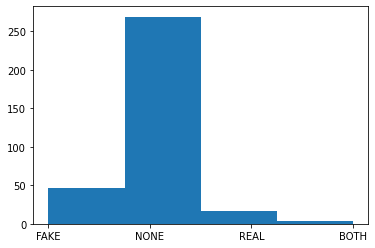

In [238]:
fr = list(UDF[(UDF['followers_ct'] > 500000) & (UDF['verified'] == True)].authored)
fig, ax = plt.subplots()
plt.hist(fr, bins=4)  
plt.show()

In [148]:
udf_real = UDF[UDF['authored'] == 'REAL']
udf_fake = UDF[UDF['authored'] == 'FAKE']

In [165]:
followers_real = [z for z in list(udf_real['followers_ct']) if z < 1000000]
followers_fake = [z for z in list(udf_fake['followers_ct']) if z < 1000000]


In [166]:
followers_fake

[403,
 2,
 1658,
 872,
 569,
 393,
 2381,
 14,
 1483,
 112,
 24,
 660,
 30,
 123,
 3252,
 25,
 815,
 322,
 4317,
 1177,
 115,
 64,
 1836,
 136,
 11,
 128,
 114,
 20,
 16,
 134,
 241,
 12,
 61475,
 15,
 9951,
 2311,
 20,
 107,
 28304,
 462,
 207,
 764,
 629,
 431,
 732,
 5,
 33,
 579,
 15,
 1152,
 1832,
 378,
 570,
 1478,
 11,
 8,
 4552,
 162,
 49,
 10679,
 617,
 21,
 601,
 3237,
 129,
 4156,
 623,
 33,
 39693,
 408,
 6,
 33,
 49581,
 68,
 2419,
 82,
 2515,
 490,
 5,
 18,
 3856,
 691,
 4419,
 19724,
 1065,
 27,
 13698,
 7091,
 1464,
 215,
 466,
 1375,
 1656,
 33,
 44,
 9,
 1336,
 248,
 5,
 2552,
 4580,
 80,
 946,
 65,
 171,
 1119,
 1710,
 226,
 2465,
 15310,
 3,
 136,
 8497,
 597,
 61,
 4,
 738,
 823,
 762,
 85,
 32,
 303,
 1606,
 994,
 1827,
 99,
 1369,
 3,
 4147,
 405,
 897,
 39468,
 344,
 641,
 83,
 12,
 7,
 1382,
 2597,
 23,
 1492,
 152,
 393,
 3719,
 89,
 934,
 44,
 8600,
 139,
 51,
 1274,
 51,
 3694,
 117,
 0,
 82,
 497,
 194,
 6,
 1,
 2041,
 1537,
 58,
 102,
 224,
 263,
 3462,
 1

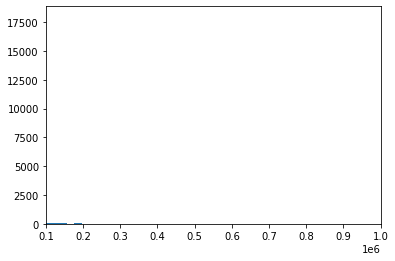

In [179]:
fig, ax = plt.subplots()
ax.set_xlim(100000, 1000000)
plt.hist(followers_real, density=False, bins=50)  
plt.show()

## Models

In [44]:
'''
Model 1

Based on verified users only.
'''

def get_predictions_authored_by_verified(B, verified_users):
    PREDICT_DICT = dict()
    A_nodes = get_article_nodes(B)
    for n in A_nodes:
        PREDICT_DICT[n] = 1 # predict fake by default
    for user in verified_users:
        edges = B.edges(user)
#         print(edges)
        for edge in edges:
            PREDICT_DICT[edge[1]] = 0
    return PREDICT_DICT

def model_based_on_verified(B, userdf):
    vf_users = list(userdf[userdf['verified'] == True].index.values)
    predict_dict = get_predictions_authored_by_verified(B, vf_users)
    return predict_dict
    
PREDS_MODEL_1 = model_based_on_verified(B, UDF)

In [317]:
'''
Model 2

Backwards -- predicting based on followers count
'''


def get_preds_from_fake_and_real(B, fke, ril):
    PREDICT_DICT = dict()
    A_nodes = get_article_nodes(B)
    for n in A_nodes:
        PREDICT_DICT[n] = 1 # predict FAKE by default
    for user in ril:
        edges = B.edges(user)
        for edge in edges:
            PREDICT_DICT[edge[1]] = 0
    return PREDICT_DICT

def model2(B, userdf):
    fake_users = list(userdf[userdf['authored'] == 'FAKE'].index.values)
    real_users = list(userdf[userdf['authored'] == 'REAL'].index.values)
    predict_dict = get_preds_from_fake_and_real(B, fake_users, real_users)
    return predict_dict
    
PREDS_MODEL_2 = model2(B, UDF)

In [319]:
'''
Model 3

Based on graph partition
'''


def get_preds_from_partition(B, goodones):
    PREDICT_DICT = dict()
    A_nodes = get_article_nodes(B)
    for n in A_nodes:
        PREDICT_DICT[n] = 1 # predict FAKE by default
    for user in goodones:
        edges = B.edges(user)
        for edge in edges:
            PREDICT_DICT[edge[1]] = 0
    return PREDICT_DICT

def model3(B, goodones):
    predict_dict = get_preds_from_partition(B, goodones)
    return predict_dict
    
PREDS_MODEL_3 = model3(B, goodones)

## Accuracy & prediction evaluation

In [47]:
def accuracy(ACTUALS, PREDS):
    TP, FP, TN, FN = 0,0,0,0
    TPl, FPl, TNl, FNl = [], [], [], []
    for i in PREDS.keys():
        if ACTUALS[i] == 0 and PREDS[i] == 0:
            TN += 1
            TNl.append(i)
        elif ACTUALS[i] == 1 and PREDS[i] == 0:
            FN += 1
            FNl.append(i)
        elif ACTUALS[i] == 0 and PREDS[i] == 1:
            FP += 1
            FPl.append(i)
        elif ACTUALS[i] == 1 and PREDS[i] == 1:
            TP += 1
            TPl.append(i)
    PRECISION = float(TP) / (TP + FP) if (TP + FP) > 0 else -1
    RECALL = float(TP) / (TP + FN) if (TP + FN) > 0 else -1
    ACCURACY = (TP + TN) / (TP + TN + FP + FN)
    print(f"Accuracy: {ACCURACY}\tPrecision: {PRECISION}\tRecall {RECALL}.")
    print(f"TP {TP}, TN {TN}, FP {FP}, FN {FN}")
    print(f"Total amount of samples: {(TP + TN + FP + FN)}")
    return (ACCURACY, PRECISION, RECALL), (TPl, FPl, TNl, FNl)

In [320]:
apr, a = accuracy(labels, PREDS_MODEL_3)
(tp, fp, tn, fn) = a

Accuracy: 0.5243243243243243	Precision: 0.524390243902439	Recall 0.8958333333333334.
TP 86, TN 11, FP 78, FN 10
Total amount of samples: 185


## Plots

In [524]:
def get_article_nodes_in_order(labels):
    f, r = [], []
    for i in labels.keys():
        if labels[i] == 1:
            f.append(i)
        else:
            r.append(i)
    return f+r

def get_subgraph_with_both_kinds_of_users(B, UDF):
    users = get_user_nodes(B)
    articles = get_article_nodes(B)
    users_sample = [u for u in users if UDF.loc[u, 'authored'] == "BOTH"]
    return B.subgraph(articles + users_sample)
    
def get_user_sample_subgraph_from_bgraph(B, pct):
    pctX1000 = pct * 1000
    users = get_user_nodes(B)
    articles = get_article_nodes(B)
    users_sample = [u for u in users if random.randint(0, 1000) <= pctX1000]
    return B.subgraph(articles + users_sample)

def plot_with_bipartition(B, labels, udf, user_param_to_color=None):
    # Separate by group
    l = get_user_nodes(B)
    r = get_article_nodes_in_order(labels)
    pos = {}

    # Update position for node from each group
    pos.update((node, (1, index)) for index, node in enumerate(l))
    pos.update((node, (2, index)) for index, node in enumerate(r))
    
    color_map = []
    for node in B.nodes:
        if isuser(node):
            if user_param_to_color != None:
                color_map.append("black")
                pass
            else: 
                color_map.append("black")
        else:
            if labels[node] == 1: # fake
                color_map.append('red')
            else:
                color_map.append('green')
    
    fig = plt.figure(figsize=(20,15))
    nx.draw(B, pos=pos, node_color=color_map)
    plt.show()

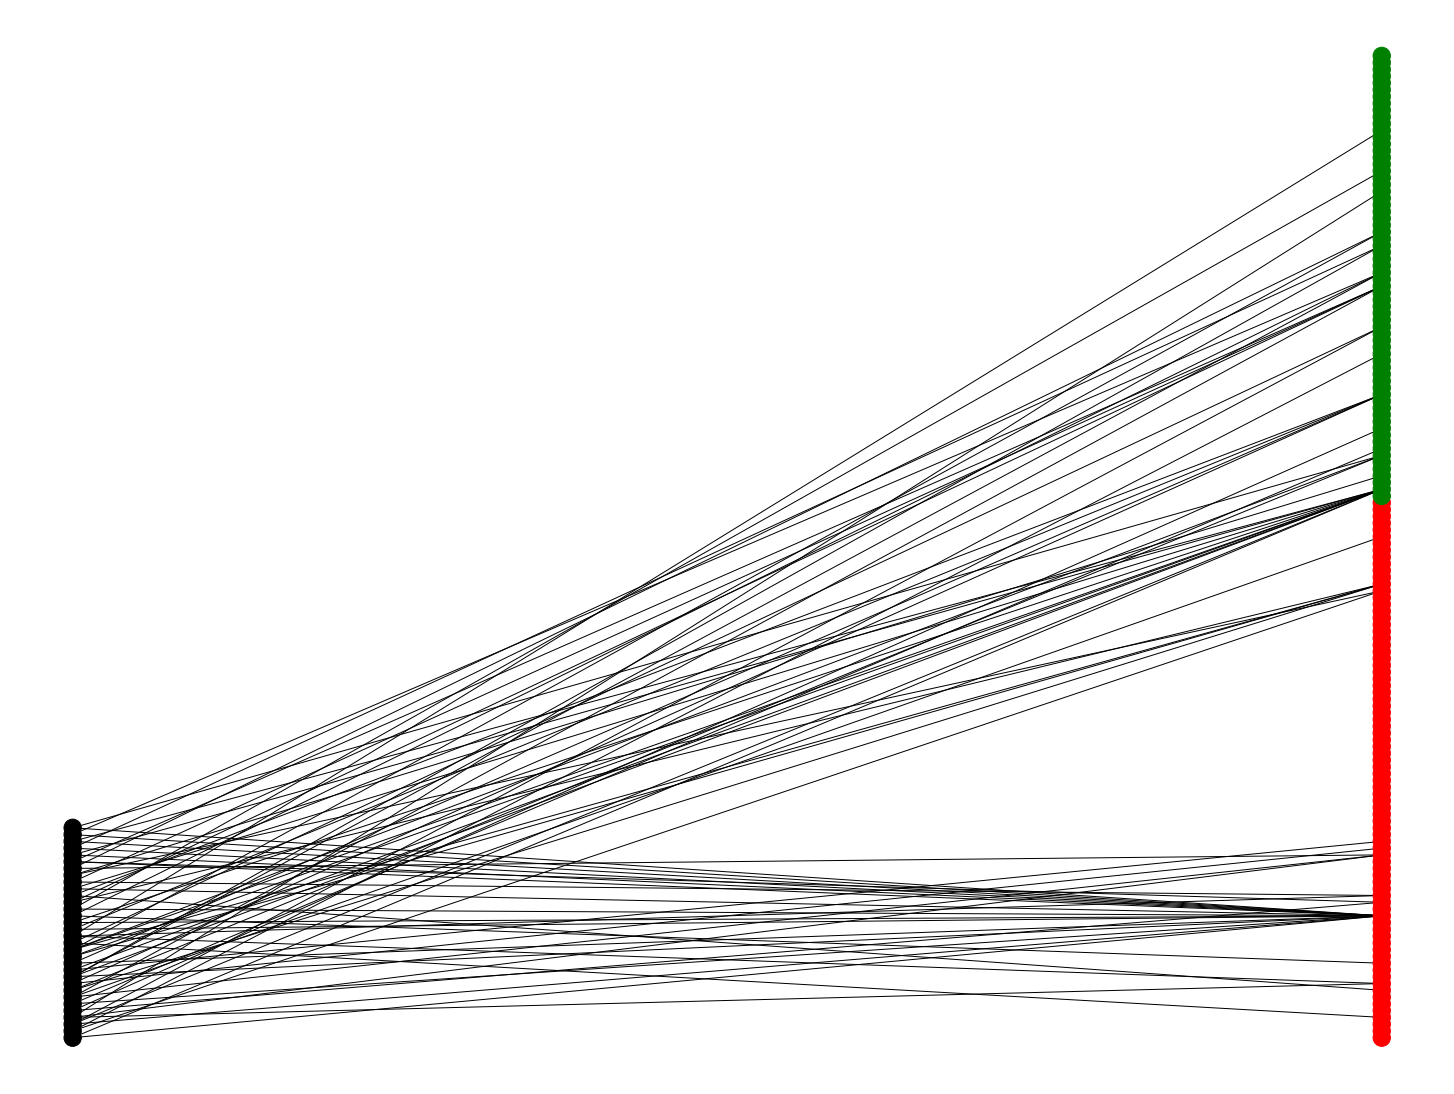

In [529]:
B_both = get_subgraph_with_both_kinds_of_users(B, UDF)
B_usample = get_user_sample_subgraph_from_bgraph(B_both, 0.03)
plot_with_bipartition(B_usample, labels, UDF)

In [535]:
UDF[UDF['authored'] == "FAKE"].sample(40)

,scrname,verified,followers_ct,friends_ct,credibility,authored
id,,,,,,
231851216,MCPRfirm,False,570,1142,-1,FAKE
2568398358,dai19751,False,3888,4570,-1,FAKE
34048949,pbcjamaica,False,2269,428,-1,FAKE
774797094448041984,aisa_coco,False,180,3177,-1,FAKE
19579400,fobr,False,2663,4080,-1,FAKE
101711178,FabianiVersace,False,158,1231,-1,FAKE
1450226238,KoshiTweet,False,263,317,-1,FAKE
2180605010,Graham_Caswell,False,1566,1958,-1,FAKE
82304064,pavan2reach,False,165,59,-1,FAKE
